In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

In [2]:
# First calibrate the camera. 
# image = mpimg.imread('camera_cal/calibration2.jpg')

images = glob.glob('camera_cal/calibration*.jpg')
## 9 x 6 chessboards are considered for the calibration of the camera. 
nx = 9
ny = 6

objpoints = []
imgpoints = []

for image_name in images:
    image = mpimg.imread(image_name)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    objp = np.zeros((6*9,3),np.float32)
    objp[ :, :2 ] = np.mgrid[0:9, 0:6].T.reshape( -1, 2)
    
    if ret==True:
        imgpoints.append(corners)
        objpoints.append(objp)
        cv2.drawChessboardCorners(image, (nx,ny), corners, ret)


In [3]:
# Identify the lane line pixels and fit with a polynomial.

leftFitSmooth = []
rightFitSmooth = []
left_fit = []
right_fit = []
def findLaneLines(warped, Minv):
    global left_fit
    global right_fit
    global value
    global leftFitSmooth
    global rightFitSmooth
    
#     Histogram of the image. 
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis = 0)
    out_img = np.dstack((warped, warped, warped))*255
    
# The below steps are to identify the lane lines. The lines are present where there are peaks in the hisotgram.
# The peaks are identified using the np.argmax function in the left half of the image and in the right half of the image. 
    mid = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:mid])
    rightx_base = np.argmax(histogram[mid:])+mid

    nonzeros = warped.nonzero()
    nonzeroy = np.array(nonzeros[0])
    nonzerox = np.array(nonzeros[1])
    
# Margin for the search window. 
    margin = 100
    minpix = 50
    
    ## This is to identify the initial the first frame. From the next frame, we reduce the search space. 
    if(value==1):
        windows = 9
        window_height = np.int(warped.shape[0])/windows
        
        leftx_curr  = leftx_base
        rightx_curr = rightx_base
        
        left_lane_inds = []
        right_lane_inds = []

        for window in range(windows):
            win_y_low       = np.int(warped.shape[0] - (window+1)*window_height)
            win_y_high      = np.int(warped.shape[0] - (window)*window_height)
            win_xleft_low   = np.int(leftx_curr - margin)
            win_xleft_high  = np.int(leftx_curr + margin)
            win_xright_low  = np.int(rightx_curr - margin)
            win_xright_high = np.int(rightx_curr + margin)
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 

            good_left_inds  = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            if len(good_left_inds) > minpix:
                leftx_curr = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_curr = np.int(np.mean(nonzerox[good_right_inds]))
        
        left_lane_inds  = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        
#     All the points in the left window and the right window are identified. 
        leftx  = nonzerox[left_lane_inds]
        lefty  = nonzeroy[left_lane_inds]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
# A second degree polynomial is fit for the points identified above in the left window and right window. 
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        leftFitSmooth  = left_fit
        rightFitSmooth = right_fit
        
        binary_warped = warped
        
#  To identify the points on the line, an array of points in the y dimension are taken.
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
        
#  To identify the corresponding X points, the left_fit and the right_fit calculated above are used.        
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        window_img = np.zeros_like(out_img)

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1  = np.array([ np.transpose(np.vstack([ left_fitx - margin , ploty]))])
        left_line_window2  = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts      = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        value = 2
        
        return left_fitx, right_fitx, ploty, left_fit, right_fit
    
    else:
        binary_warped = warped
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
        
        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
#         diff1 = (np.array(left_fit)-np.array(leftFitSmooth))/np.array(leftFitSmooth)
#         diff2 = (np.array(right_fit)-np.array(rightFitSmooth))/np.array(rightFitSmooth)
        
#         if np.sum(diff1)>0.15 or np.sum(diff2)>0.15:
#             pass
#         else:
#             leftFitSmooth = left_fit
#             rightFitSmooth = right_fit
        
#         ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
#         left_fitx = leftFitSmooth[0]*ploty**2 + leftFitSmooth[1]*ploty + leftFitSmooth[2]
#         right_fitx = rightFitSmooth[0]*ploty**2 + rightFitSmooth[1]*ploty + rightFitSmooth[2]
        
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        return left_fitx, right_fitx, ploty, left_fit, right_fit

In [187]:
def find_curv( left_fitx, right_fitx, ploty, left_fit, right_fit ):
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    y_eval = np.max(ploty)
    left_curverad  = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    radiuses.append([left_curverad, right_curverad])
    return left_curverad, right_curverad

In [183]:
# Test image for the function undistortion

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
test_image = mpimg.imread('test_images/test5.jpg')
undist = cv2.undistort(test_image, mtx, dist, None, mtx)

def undistort(image):
    undist_image = cv2.undistort(image, mtx, dist, None, mtx)
    return undist_image

In [184]:
# Apply the perspective transform to the image. Take the trapezoidal zone and do that

def warp(final_image): 
    
    img_size = np.shape(image)
    src = np.float32([[700,450],[1150,719],[200,719],[600,450]])
    dst = np.float32([[980,0],[980,719],[375,719],[375,0]])
#     src = np.float32([[0, img_size[0]], [img_size[1],img_size[0]], [768, 480], [512,480] ])
#     dst = np.float32([[0,img_size[0]],[img_size[1],img_size[0]],[img_size[1],0],[0,0]])
    
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    img_shape = ( final_image.shape[1], final_image.shape[0])
    warped = cv2.warpPerspective( final_image, M, img_shape , flags=cv2.INTER_LINEAR)
    return warped, M, Minv
    

In [142]:
def apply_masking(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lowerHSV  = np.array([ 20, 60, 60])
    higherHSV = np.array([ 38, 174 , 250])
    mask = cv2.inRange(hsv, lowerHSV, higherHSV)
    return mask

In [143]:
def mag_thresh(img, sobel_kernel = 3):
    
    mag_thresh = [80,255]
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255.0
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    return binary_output

In [163]:
def dir_thresh(image, sobel_kernel = 3):
    thresh = [0.7, 1.3]
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    return binary_output

In [164]:
## Check the S channel threshold values once. 
## Can I use Sobel on the S channel - I don't think it matters much. 

def edges(image):
    
    kernel_size = 5
    image = cv2.GaussianBlur( image, (kernel_size, kernel_size),0)
    
    image_hls  = cv2.cvtColor( image, cv2.COLOR_RGB2HLS)
    image_lab  = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
#     print ("The B channel of the Image")
#     plt.imshow(image_lab[:,:,2], cmap = 'Greys_r')
#     plt.show()
    
    gray_image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY )
    mask1 = apply_masking(image)
#     print("The mask1 is:")
#     plt.imshow(mask1)
#     plt.show()
    lower = np.array([ 200])
    upper = np.array([ 255])
    
    mask2 = cv2.inRange(image_hls[:,:,1], lower, upper)   
#     print("This is the mask2 image")
#     plt.imshow(mask2, cmap = 'Greys_r')
#     plt.show()
    
    final_mask = cv2.bitwise_or(mask1, mask2)
    
    ## S Channel in the HLS Image.
    threshS = [150 , 255.0]
    
    image_hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
#     S = image_hls[:,:,2]
#     binary_image_cc = np.zeros_like(S)
#     binary_image_cc[(S>threshS[0])&(S<threshS[1])]=1
    
    L = image_hls[:,:,1]
#     print ("L channel is: ")
#     plt.imshow(L, cmap = 'Greys_r')
#     plt.show()
#     print ("This is the L channel")
#     plt.imshow(L, cmap = 'Greys_r')
#     plt.show()
    
    ## Sobel Operators applied on the Image. 
    threshX = [ 20, 255]
    threshY = [ 60, 255]
    sobelx = cv2.Sobel( mask1 , cv2.CV_64F, 1, 0, ksize = 7)
    sobely = cv2.Sobel( mask2 , cv2.CV_64F, 1, 0, ksize = 7)
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    sxbinary = np.zeros_like(scaled_sobel)
    sybinary = np.zeros_like(scaled_sobely)
    sxbinary[(scaled_sobel>threshX[0])&(scaled_sobel<threshX[1])]=1
    sybinary[(scaled_sobely>threshY[0])&(scaled_sobely<threshY[1])]=1
    
    magBinary = mag_thresh(image)
    gradDirBinary = dir_thresh(image)
    
    final_img = np.zeros_like(final_mask)
    final_img = cv2.bitwise_or( final_img, final_mask)
#     print ("Shape of sobelx is: ",sobelx.shape)
    final_img = cv2.bitwise_or( final_img, sxbinary)
    final_img = cv2.bitwise_or( final_img, sybinary )
    
#     mask_ = np.zeros_like(final_img)
#     mask_[:, :350] = 1
#     mask_[:, 1000:] = 1
#     print("This is the final iamage")
#     print("The final image is: ")
#     plt.imshow(final_img, cmap = 'Greys_r')
#     plt.show()
    
    return final_img

In [165]:
# Create an image to draw the lines on
import functools

def unwarp_image(undist, warped, Minv, left_fitx, ploty, right_fitx):
    
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left  = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly( color_warp, np.int_([pts]), (255,0, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result


In [219]:
def find_position(image_shape,left,right):
    # Find the position of the car from the center
    # It will show if the car is 'x' meters from the left or right
    camera_position = image_shape[1]/2
    lane_center = (right+left)/2
    offset_pixels = abs(camera_position-lane_center)
    offset_meters = (offset_pixels/(right-left))*3.7
    return offset_meters

In [220]:
lastLeftFit  = []
lastRightFit = []

def process_image(image):
    
    global lastLeftFit
    global lastRightFit
    
    image = undistort(image)
    imageWarped, M, Minv = warp(image)
#     print ("This is the warped image")
#     plt.imshow(imageWarped)
#     plt.show()
    image_edges = edges(imageWarped)
    
    leftFitX, rightFitX, plotY, leftFit, rightFit = findLaneLines (image_edges, Minv)
    left_curverad, right_curverad  = find_curv( leftFitX, rightFitX, plotY, leftFit, rightFit )

    if (len(lastLeftFit)==0):
        lastLeftFit  = leftFit
        lastRightFit = rightFit
    else:
        l1 = np.array(lastLeftFit)
        l2 = np.array(leftFit)
        r1 = np.array(lastRightFit)
        r2 = np.array(rightFit)
        if(max(((l2-l1)/l1)>0.05) or max(((r2-r2)/r1)>0.05)):
            pass
        else:
            lastLeftFit = leftFit
            lastRightFit = rightFit
    
    find_curv( leftFitX, rightFitX, plotY, lastLeftFit, lastRightFit)
    final_image = unwarp_image(image, image_edges, Minv, leftFitX, plotY, rightFitX)
    
    curvature = (left_curverad, right_curverad)
    font = cv2.FONT_HERSHEY_SIMPLEX
    left = "Left Radius of Curvature: {} m".format(int(left_curverad))
    right = "Right Rdius of Curvature: {} m".format(int(right_curverad))
    
    cv2.putText(final_image,left,(0,50), font, 1,(255,255,255),2)
    cv2.putText(final_image,right,(0,100), font, 1,(255,255,255),2)
    position = find_position(image.shape, leftFitX[719],rightFitX[719])

    carPosition = "car position from center: {}".format(position)
    cv2.putText(final_image, carPosition, (0,150),font, 1, (255,255,255),2)
    return final_image
    

In [221]:
from PIL import Image
im = Image.open('test/t14.png')
rgb_im = im.convert('RGB')
rgb_im.save('test/t14.jpg')

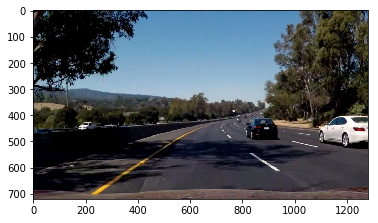

The src is:  [[    0.   720.]
 [ 1280.   720.]
 [  768.   480.]
 [  512.   480.]]
The dst is:  [[    0.   720.]
 [ 1280.   720.]
 [ 1280.     0.]
 [    0.     0.]]


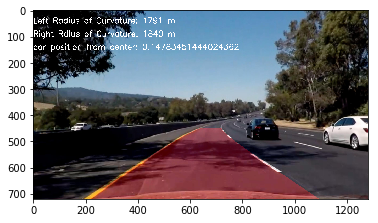

In [223]:
from PIL import Image
value = 1
im = mpimg.imread('test/t12.jpg')
im = cv2.resize(im, (1280,720))
plt.imshow(im)
plt.show()

img_size = np.shape(im)
src = np.float32([[0, img_size[0]], [img_size[1],img_size[0]], [768, 480], [512,480] ])
dst = np.float32([[0,img_size[0]],[img_size[1],img_size[0]],[img_size[1],0],[0,0]])
print("The src is: ",src)
print("The dst is: ",dst)
result = process_image(im)
result2 = Image.fromarray(result)
result2.save('images_test/test6.jpg')
plt.imshow(result2)
plt.show()


In [224]:
# Testing on Videos
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [225]:
white_output = 'project.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!

%time white_clip.write_videofile(white_output, audio=True)

[MoviePy] >>>> Building video project.mp4
[MoviePy] Writing audio in projectTEMP_MPY_wvf_snd.mp3


100%|██████████| 1112/1112 [00:01<00:00, 629.05it/s]

[MoviePy] Done.
[MoviePy] Writing video project.mp4



100%|█████████▉| 1260/1261 [14:01<00:00,  1.68it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project.mp4 

CPU times: user 16min 13s, sys: 1min 22s, total: 17min 35s
Wall time: 14min 4s


In [226]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))